In [7]:
# importing libraries
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats           #scipy是一個開源的Python演算法庫和數學工具包
from scipy.signal import find_peaks  #找到波型的最高點
import warnings
warnings.filterwarnings('ignore')

In [8]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# reading raw data file
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
har_df = pd.read_table('/content/drive/MyDrive/0526時間序列/WISDM_ar_v1.1_raw.txt', header = None, names = columns, sep=",")

In [24]:
har_df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1086471,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1086472,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1086473,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1086474,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [11]:
# removing null values
har_df = har_df.dropna()   #刪除缺失值
har_df.shape  #108萬筆資料、6個欄位

(1086475, 6)

In [12]:
har_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086475 entries, 0 to 1086475
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user       1086475 non-null  int64  
 1   activity   1086475 non-null  object 
 2   timestamp  1086475 non-null  int64  
 3   x-axis     1086475 non-null  float64
 4   y-axis     1086475 non-null  float64
 5   z-axis     1086475 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


In [13]:
# drop the rows where timestamp is 0
df = har_df[har_df['timestamp'] != 0]

In [14]:
# now arrange data in ascending order of the user and timestamp
df = df.sort_values(by = ['user', 'timestamp'], ignore_index=True)  #時間一定要按照順序排

# 目標:想透過x、y、z三軸來預測正在做甚麼動作

# 時間序列分析方法:將資料切成很多小塊，設定一個window size(往回顧幾天)這樣去掃描資料

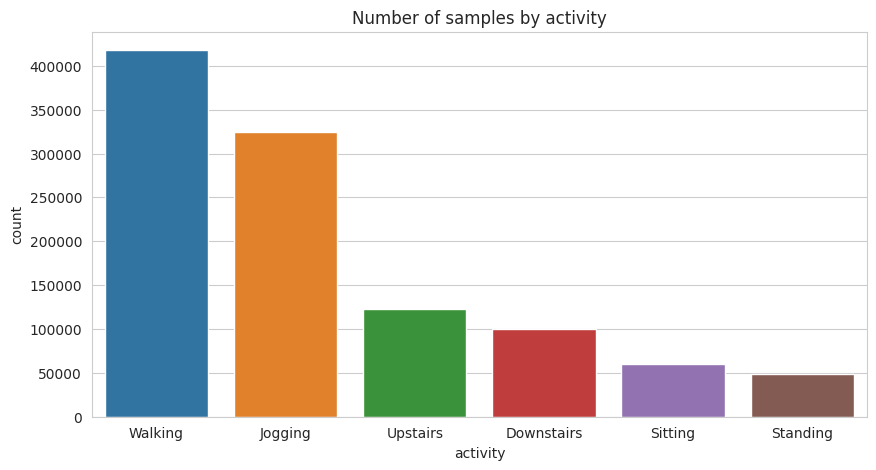

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize = (10, 5))
sns.countplot(x = 'activity', data = df)
plt.title('Number of samples by activity')
plt.show()

# 看波長

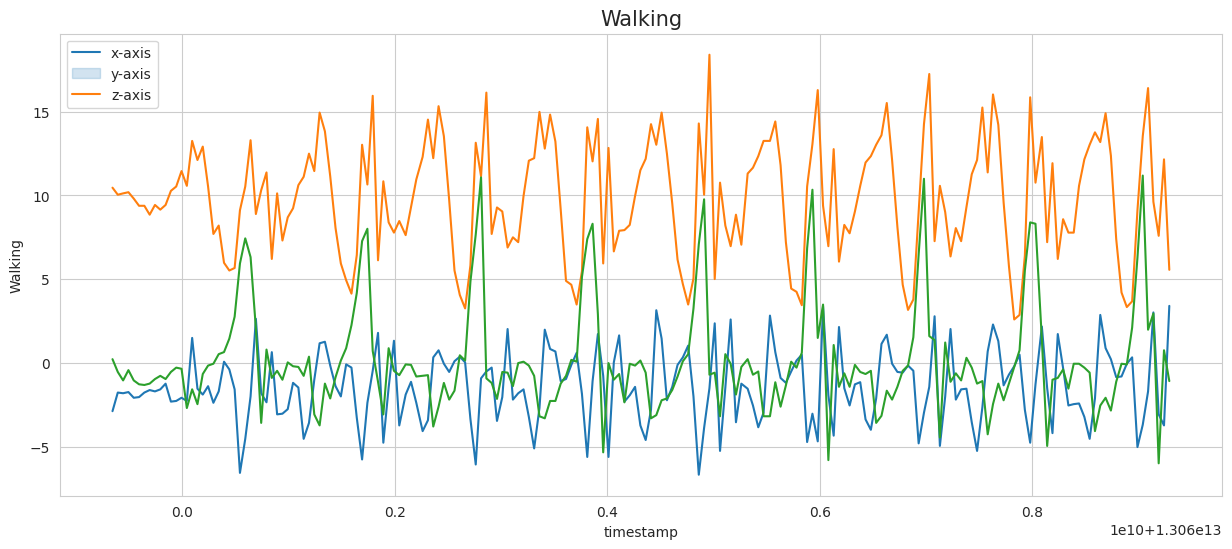

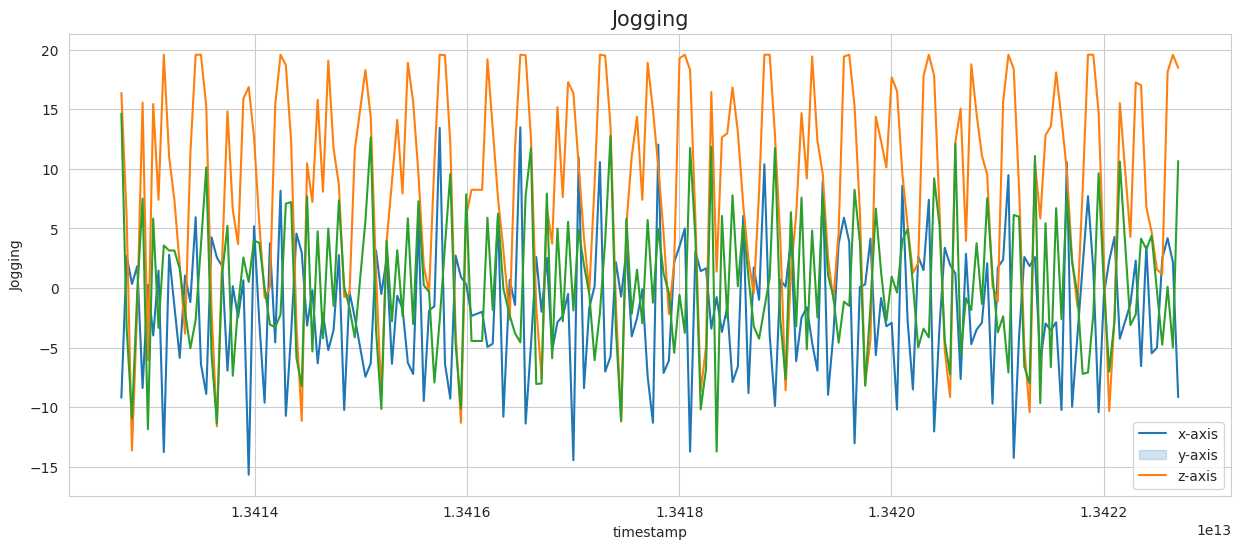

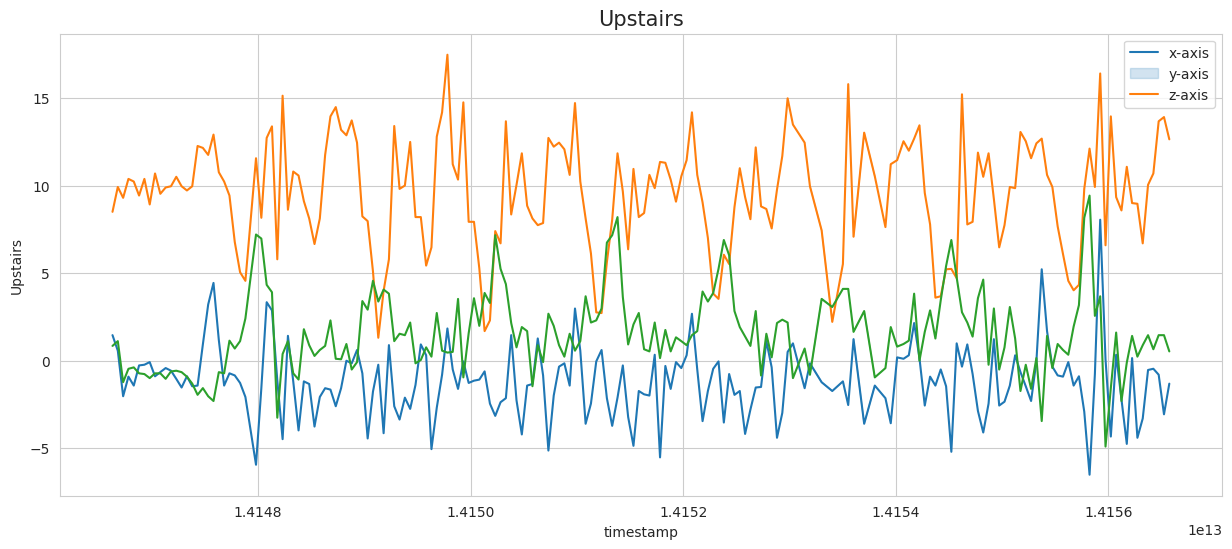

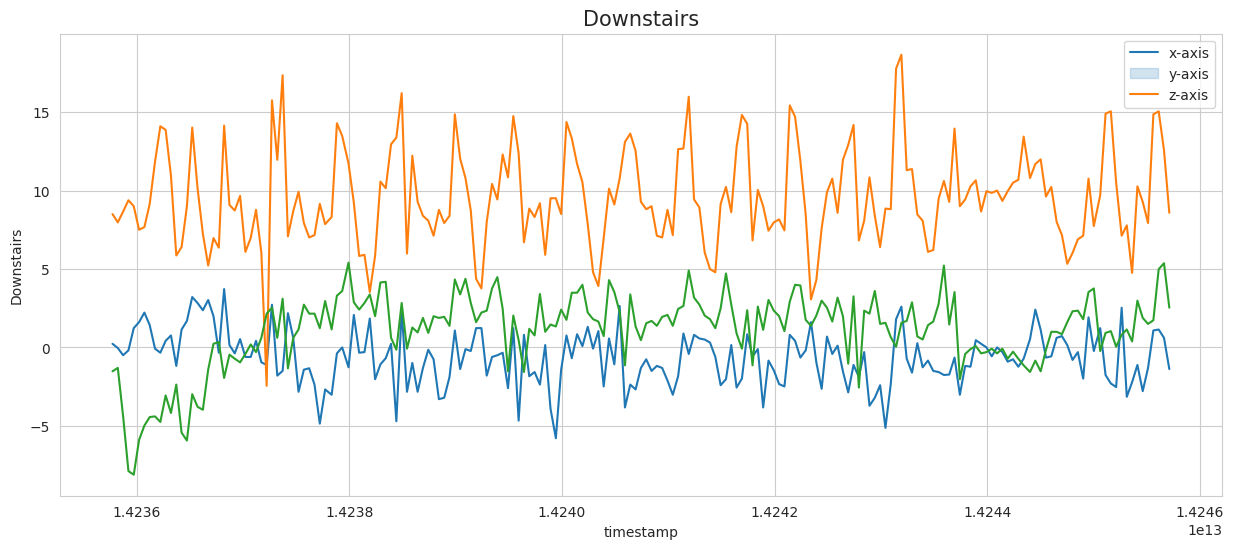

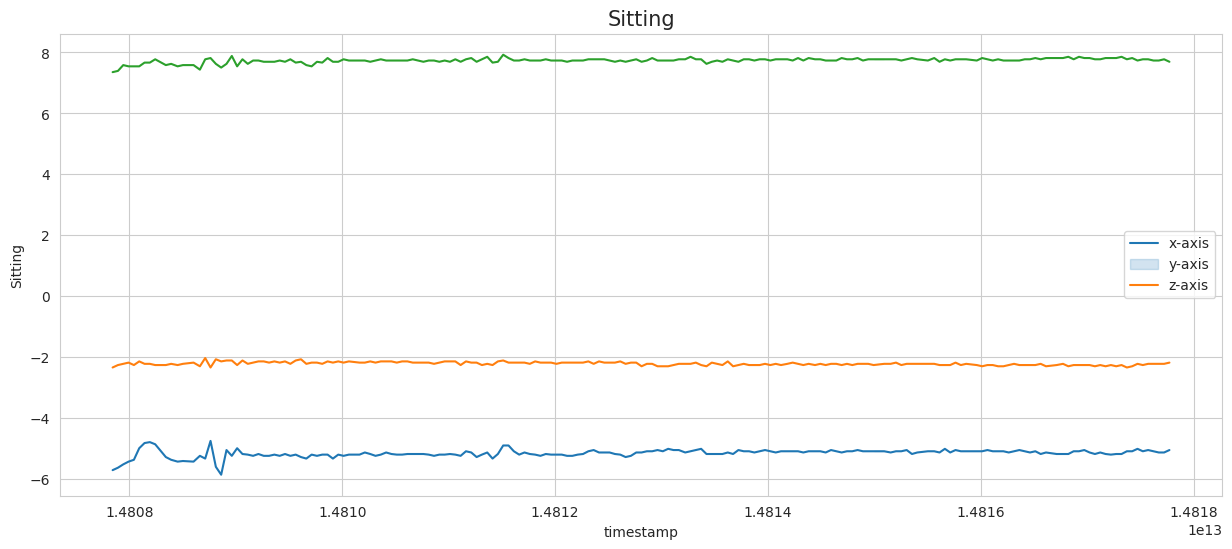

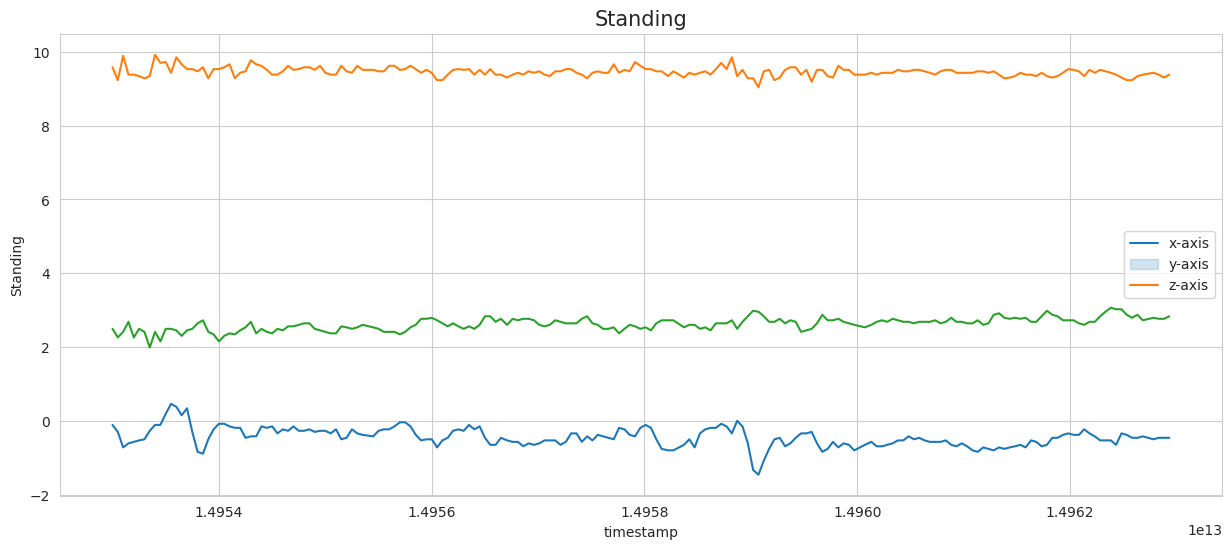

In [16]:
for i in ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']:
  data_36 = df[(df['user'] == 36) & (df['activity'] == i)][:200]
  plt.figure(figsize = (15, 6))
  sns.lineplot(y = 'x-axis', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'y-axis', x = 'timestamp', data = data_36)
  sns.lineplot(y = 'z-axis', x = 'timestamp', data = data_36)
  plt.legend(['x-axis', 'y-axis', 'z-axis'])
  plt.ylabel(i)
  plt.title(i, fontsize = 15)
  plt.show()

# 將資料切割

In [17]:
# train data -> Users upto User ID = 27 (i.e. 27 users)
df_train = df[df['user'] <= 27]
# test data -> Users from User ID = 28 to 36 (i.e. 9 users)
df_test = df[df['user'] > 27]

In [18]:
x_list = []
y_list = []
z_list = []
train_labels = []

window_size = 100
step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_train.shape[0] - window_size, step_size): #1-100、150-250
    xs = df_train['x-axis'].values[i: i + 100]
    ys = df_train['y-axis'].values[i: i + 100]
    zs = df_train['z-axis'].values[i: i + 100]
    label = stats.mode(df_train['activity'][i: i + 100])[0][0]  #取眾數

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

# 傅立葉轉換

In [19]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])  #發現最多有51個單音波
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

# 測試資料集，也要做特徵工程

In [20]:
x_list = []
y_list = []
z_list = []
test_labels = []

window_size = 100
step_size = 50

# creating overlaping windows of size window-size 100
for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x-axis'].values[i: i + 100]
    ys = df_test['y-axis'].values[i: i + 100]
    zs = df_test['z-axis'].values[i: i + 100]
    label = stats.mode(df_test['activity'][i: i + 100])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

In [21]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

In [25]:
X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,z_peak_count_fft,x_skewness_fft,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft
0,3.6538,9.8101,-0.4788,5.508084,3.914714,3.201477,4.200456,3.173296,2.261984,-7.35,...,15,2.283846,2.876810,1.942716,5.902973,9.730612,3.525171,3044.696352,1543.929460,1027.602156
1,3.8267,10.0261,-0.6779,5.543900,4.265195,3.200549,4.245502,3.438856,2.196162,-9.58,...,17,1.672484,2.424683,1.039303,2.230341,5.947909,0.596694,3083.677660,1826.844868,1030.777484
2,3.8955,10.0714,-0.6730,5.942122,4.408135,3.365199,4.611740,3.497088,2.345800,-9.58,...,15,1.379378,2.136491,1.238485,1.333222,5.573774,1.710798,3532.300356,1943.213404,1163.838904
3,4.0975,10.0045,-0.4714,5.787474,4.372943,3.437675,4.400350,3.444650,2.444004,-8.24,...,12,1.546561,2.452121,1.667444,1.753765,8.225041,3.616595,3349.909876,1915.293756,1204.323104
4,3.8653,9.9209,-0.5538,5.843144,4.713848,3.454630,4.424276,3.842882,2.513868,-8.96,...,14,1.176388,2.745149,2.484931,0.704434,11.172352,8.054639,3415.034116,2222.040340,1197.731656


從上述發現，波已經被拆分，它不在是波了，可以開始利用機器學習做特徵工程

拿一段小波做各種特徵工程，產出很多欄位就可以利用機器學習去分析

In [22]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler() #每個特徵工程，值域都不同，所以要正規化
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8439224061220858

 -------------Classification Report-------------

              precision    recall  f1-score   support

  Downstairs       0.68      0.76      0.72       576
     Jogging       0.81      0.94      0.87      1522
     Sitting       0.89      0.98      0.93       361
    Standing       0.94      0.84      0.89       322
    Upstairs       0.70      0.65      0.67       640
     Walking       0.95      0.83      0.88      2198

    accuracy                           0.84      5619
   macro avg       0.83      0.83      0.83      5619
weighted avg       0.85      0.84      0.84      5619

